In [1]:
import source.preprocess as prep
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from sklearn.model_selection import train_test_split

In [3]:
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')

if torch.cuda.is_available():
    print("=> Using GPU")
    print("CUDA device count =")
    print (torch.cuda.device_count())
    print("Selecting decvice = cuda:0")
    device = torch.device("cuda:0")
    print("Device name = ")
    print (torch.cuda.get_device_name(0))
else:
    print("=> Using CPU")
    device = torch.device("cpu")

=> Using GPU
CUDA device count =
2
Selecting decvice = cuda:0
Device name = 
NVIDIA GeForce RTX 2080


In [4]:
randstate = 0
np.random.seed(randstate)
torch.manual_seed(randstate)
if device == torch.device("cuda:0"):
    randstate = 0 # RCC fela #1234
    np.random.seed(randstate)
    torch.manual_seed(randstate)
    torch.cuda.manual_seed_all(randstate)

In [5]:
def create_one_hot(df):
    """
    function description: create one hot encoded tensors
    
    """
    # We will use this dictionary to map each character to an integer so that it can be used as an input to our ML models:
    dict_int2aa = {0:"A",1:"C",2:"D",3:"E",4:"F",5:"G",6:"H",7:"I",8:"K",9:"L",10:"M",11:"N",12:"P",13:"Q",14:"R",15:"S",16:"T",17:"V",18:"W",19:"Y",20:"-"}

    token2int = {x:i for i, x in enumerate('ACDEFGHIKLMNPQRSTVWY-')}

    train_inputs = prep.preprocess_inputs(df, token2int)
    


    hot_inputs = np.zeros((train_inputs.shape[0], positions, 21))
    for sample in range(train_inputs.shape[0]):
        hot_encoded = prep.OneHot_encode(train_inputs, sample)
        #print(hot_inputs.shape, hot_encoded)
        hot_inputs[sample, :,:] = hot_encoded
        
    return hot_inputs

## Model assembly ..
https://github.com/zacheberhart/Maximum-Mean-Discrepancy-Variational-Autoencoder/blob/master/MMD-VAE%20(InfoVAE).ipynb

In [6]:
class Encoder(nn.Module):
    
    def __init__(self, seq_len, aa_var, zdim, alpha):
        super(Encoder, self).__init__()
        
        self.q  = seq_len * aa_var
        self.hsize=int(1.5*self.q)
        #self.en_mu = nn.Linear(self.hsize, d)
        #self.en_std = nn.Linear(self.hsize, d) 
        
        self.model = nn.Sequential(
            #encoder layer 1
            nn.Linear(self.q, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Dropout(p=0.3),
            
            #encoder layer 2
            nn.Linear(self.hsize, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            nn.BatchNorm1d(self.hsize), # BN1
            
            #encoder layer 3
            nn.Linear(self.hsize, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            #nn.BatchNorm1d(self.hsize), # BN1
            
            nn.Linear(self.hsize, zdim)
        )
    def forward(self, x):
        x = x.view(x.size(0), self.q)
        return self.model(x)

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, seq_len, aa_var, zdim, alpha):
        super(Decoder, self).__init__()
        
        self.q = seq_len * aa_var
        self.zdim = zdim
        self.hsize=int(1.5*self.q)
        
        self.model = nn.Sequential(
            #decoder layer 1
            nn.Linear(zdim, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            nn.BatchNorm1d(self.hsize), #BN2
            
            #decoder layer 2
            nn.Linear(self.hsize, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            nn.Dropout(p=0.3),
            
            #decoder layer 3
            nn.Linear(self.hsize, self.hsize),
            nn.LeakyReLU(alpha, inplace=True),
            nn.BatchNorm1d(self.hsize), 
            
            nn.Linear(self.hsize, self.q),
            #nn.BatchNorm1d(self.q), #BNfinal
        )
    def forward(self, z):
        outputs = self.model(z)
        outputs = outputs.view(z.size(0), seq_len, aa_var)
        outputs = nn.Softmax(dim = 2)(outputs)
        return outputs

In [8]:
class MMD_VAE(nn.Module):
    def __init__(self, zdims):
        super(MMD_VAE, self).__init__()
        self.zdims = zdims
        self.encoder = Encoder(seq_len, aa_var, self.zdims, alpha)
        self.decoder = Decoder(seq_len, aa_var, self.zdims, alpha)
    
    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return z, recon_x

In [9]:
def loss_function(recon_x, x, z):
    batch_size = x.size(0)
    zdim = z.size(1)
    true_samples = torch.randn(batch_size, zdim, requires_grad = False).to(device)

    loss_MMD = compute_mmd(true_samples, z)
    loss_REC = (recon_x - x).pow(2).mean()

    return loss_REC + 2*loss_MMD, loss_REC, loss_MMD

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)

    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [10]:
# The training function
def train(model, epoch, batch_per_epoch, v_train):
    
    optimizer = optim.Adam(model.parameters(), lr = 2e-5, weight_decay=0) # 2e-4
    
    # batching and training
    ind = np.arange(v_train.shape[0])
    
    for i in range(batches_per_epoch):
        data = torch.FloatTensor(v_train[np.random.choice(ind, size=batch_size)]) 
        data = data.to(device)
        optimizer.zero_grad()
        z, recon_batch = model(data)
        loss, _, _ = loss_function(recon_batch, data, z)
        loss.backward()
        optimizer.step()
    
    # training loss
    data = torch.FloatTensor(v_train)
    data = data.to(device)
    z, recon_batch = model(data)
    train_loss, train_loss_rec, train_loss_mmd = loss_function(recon_batch, data, z)
    
    train_loss = train_loss.cpu().detach().numpy() 
    train_loss_rec = train_loss_rec.cpu().detach().numpy() 
    train_loss_mmd = train_loss_mmd.cpu().detach().numpy() 
    
    if (epoch % 2 == 0):
        print('====> Epoch %d done! Train loss = %.2e, Train loss rec = %.2e, Train loss mmd = %.2e' \
              % (epoch, train_loss, train_loss_rec, train_loss_mmd))
    
    return train_loss, train_loss_rec, train_loss_mmd #train_loss, val_loss, train_loss_MSE, val_loss_MSE

def test(model, epoch, v_val):
    model.eval()
    
    with torch.no_grad():
        data = torch.FloatTensor(v_val)
        data = data.to(device)
        z, recon_batch = model(data)
        
        _, test_loss, _ = loss_function(recon_batch, data, z)
        test_loss = test_loss.cpu().detach().numpy() 
        
    if (epoch % 2 == 0):
        print('====> Test loss rec: %.2e\n' %test_loss)
    return test_loss

# Serine protease (S1A)

## Prepare Data

In [11]:
# path to collect the sequence data    
main_path = 'training_data'    
S1A_path = main_path + '/s1Ahalabi_1470_nosnakesprocessed.fasta'

# read the sequence data
S1A_sequences, S1A_headers = prep.get_seq(S1A_path, get_header=True)

# clean up data
sample, positions = len(S1A_sequences), len(S1A_sequences[0])
S1A_MSA = prep.create_MSA(S1A_sequences, sample, positions)

# pandas dataframe format
S1A_df = pd.DataFrame(S1A_MSA)
S1A_df.columns = ['Sequence']

# create S1A dataset into one hot encoded tensors: shape --> (datasize, protein_len, aa_labels)
S1A_onehot_inputs = create_one_hot(S1A_df)

# hyperparameters ...
z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = S1A_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width

## Train InfoVAE model (test training)

To make sure train and valid loss do not diverge much.

In [17]:
batch_size = 64
over_batch = 8
nb_epochs = 30
val_frac = .15

batches_per_epoch = np.int32(over_batch*np.ceil(S1A_onehot_inputs.shape[0]/batch_size))

idx = np.arange(len(S1A_onehot_inputs))

model = MMD_VAE(zdims = z_dim).to(device)
model.train()

v_train, v_val, idx_train, idx_val = \
train_test_split(S1A_onehot_inputs, idx, test_size=val_frac, random_state=randstate+1)

loss_train = []
loss_train_rec = []
loss_train_mmd = []
loss_test = [] 
for epoch in range(1, nb_epochs+1):
    tl, tlr, tlm = train(model, epoch, batches_per_epoch, v_train)
    ltest = test(model, epoch, v_val) # here is reconstruction loss only...
    
    loss_train.append(tl)
    loss_train_rec.append(tlr)
    loss_train_mmd.append(tlm)
    loss_test.append(ltest)

====> Epoch 2 done! Train loss = 3.72e-02, Train loss rec = 3.09e-02, Train loss mmd = 3.16e-03
====> Test loss rec: 3.08e-02

====> Epoch 4 done! Train loss = 3.75e-02, Train loss rec = 2.99e-02, Train loss mmd = 3.77e-03
====> Test loss rec: 3.02e-02

====> Epoch 6 done! Train loss = 4.45e-02, Train loss rec = 3.01e-02, Train loss mmd = 7.20e-03
====> Test loss rec: 3.07e-02

====> Epoch 8 done! Train loss = 3.53e-02, Train loss rec = 2.91e-02, Train loss mmd = 3.12e-03
====> Test loss rec: 2.99e-02

====> Epoch 10 done! Train loss = 3.32e-02, Train loss rec = 2.85e-02, Train loss mmd = 2.34e-03
====> Test loss rec: 2.92e-02

====> Epoch 12 done! Train loss = 3.86e-02, Train loss rec = 2.81e-02, Train loss mmd = 5.25e-03
====> Test loss rec: 2.90e-02

====> Epoch 14 done! Train loss = 4.03e-02, Train loss rec = 2.82e-02, Train loss mmd = 6.02e-03
====> Test loss rec: 2.93e-02

====> Epoch 16 done! Train loss = 3.42e-02, Train loss rec = 2.75e-02, Train loss mmd = 3.35e-03
====> Test 

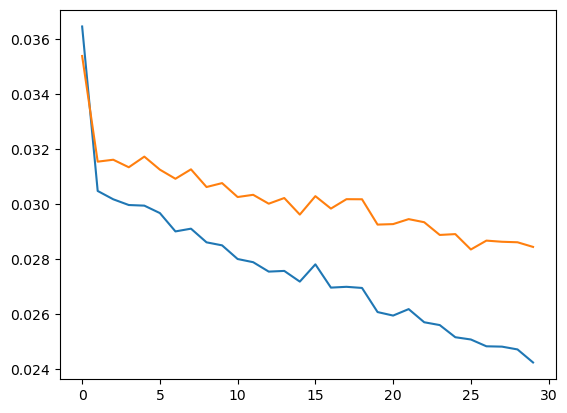

In [19]:
#2e-5
for i in (
loss_train_rec,
#loss_train_MSE,
loss_test,
#loss_val_MSE
         ):
    plt.plot(i)

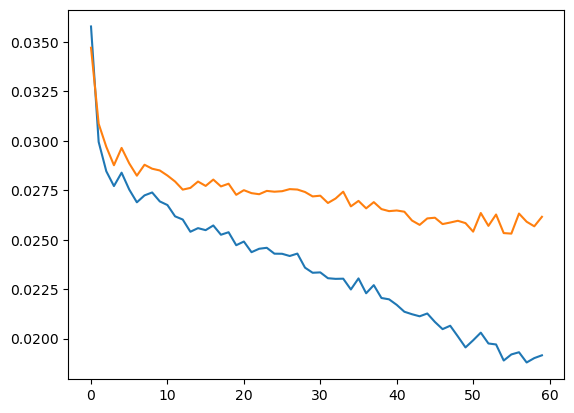

In [16]:
#5e-5
for i in (
loss_train_rec,
#loss_train_MSE,
loss_test,
#loss_val_MSE
         ):
    plt.plot(i)

## Train the model for analysis on all sequences in the dataset

In [18]:
S1A_onehot_inputs.shape, v_train.shape

((1344, 205, 21), (1142, 205, 21))

In [12]:
batch_size = 64
over_batch = 8
nb_epochs = 30

batches_per_epoch = np.int32(over_batch*np.ceil(S1A_onehot_inputs.shape[0]/batch_size))

model = MMD_VAE(zdims = z_dim).to(device)
model.train()

loss_train = []
loss_train_rec = []
loss_train_mmd = []
for epoch in range(1, nb_epochs+1):
    tl, tlr, tlm = train(model, epoch, batches_per_epoch, S1A_onehot_inputs)
    model.eval()
    
    loss_train.append(tl)
    loss_train_rec.append(tlr)
    loss_train_mmd.append(tlm)

====> Epoch 2 done! Train loss = 5.76e-02, Train loss rec = 3.05e-02, Train loss mmd = 1.36e-02
====> Epoch 4 done! Train loss = 4.36e-02, Train loss rec = 2.94e-02, Train loss mmd = 7.09e-03
====> Epoch 6 done! Train loss = 2.97e-02, Train loss rec = 2.91e-02, Train loss mmd = 2.76e-04
====> Epoch 8 done! Train loss = 4.38e-02, Train loss rec = 2.89e-02, Train loss mmd = 7.44e-03
====> Epoch 10 done! Train loss = 3.18e-02, Train loss rec = 2.83e-02, Train loss mmd = 1.71e-03
====> Epoch 12 done! Train loss = 3.21e-02, Train loss rec = 2.82e-02, Train loss mmd = 1.92e-03
====> Epoch 14 done! Train loss = 3.73e-02, Train loss rec = 2.81e-02, Train loss mmd = 4.60e-03
====> Epoch 16 done! Train loss = 3.65e-02, Train loss rec = 2.70e-02, Train loss mmd = 4.71e-03
====> Epoch 18 done! Train loss = 3.22e-02, Train loss rec = 2.70e-02, Train loss mmd = 2.61e-03
====> Epoch 20 done! Train loss = 2.85e-02, Train loss rec = 2.63e-02, Train loss mmd = 1.08e-03
====> Epoch 22 done! Train loss = 

In [13]:
model = model.cpu()
torch.cuda.empty_cache() 

v_all = torch.FloatTensor(S1A_onehot_inputs)
S1A_z_dim = model.encoder(v_all).detach().numpy() 

In [14]:
non_verb = []
verb = []
for num, i in enumerate(S1A_headers):
    if 'not vertebrate' in i:
        non_verb.append(num)
    else:
        verb.append(num)
non_verb = np.array(non_verb)
verb = np.array(verb)

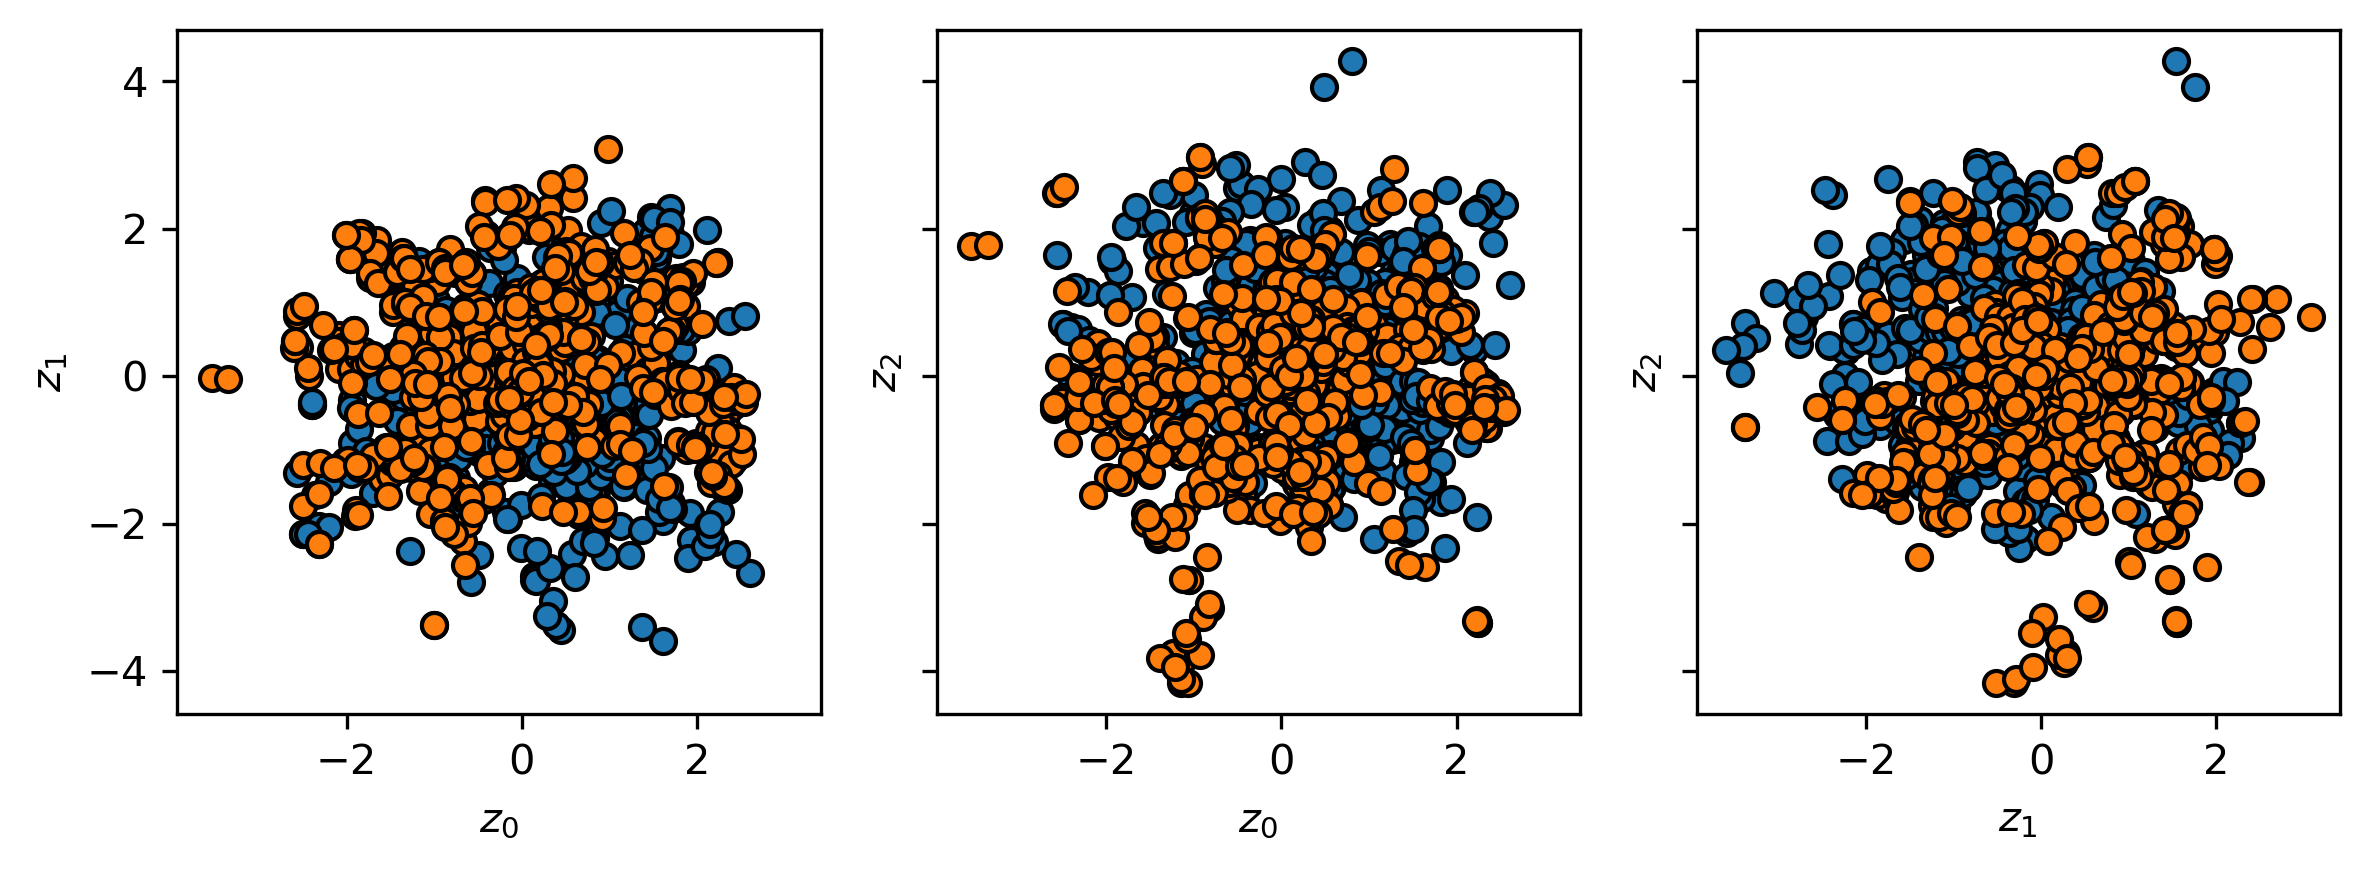

In [15]:
fig, axes = plt.subplots(1,3, figsize = (8,3), dpi = 300, sharex= True, sharey = True )

for label in [non_verb, verb]:
    plot1 = axes[0].scatter(
        S1A_z_dim[label,0],
        S1A_z_dim[label,1],
        edgecolor = 'k'
    )
    plot2 = axes[1].scatter(
        S1A_z_dim[label,0],
        S1A_z_dim[label,2],
        edgecolor = 'k'
    )
    plot3 = axes[2].scatter(
        S1A_z_dim[label,1],
        S1A_z_dim[label,2],
        edgecolor = 'k'
    )

#axes[0].set_xlim([-3., 3.]) 
#axes[0].set_ylim([-3., 3.])
#plot1.set_clim([-4, 0.5])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()

In [18]:
tryp = []
chym = []
for num, i in enumerate(S1A_headers):
    if '|trypsin' in i or '|tryptase' in i or '|kallikrein' in i:
        tryp.append(num)
    else if '|chymotrypsin' in i:
        chym.append(num)
chym = np.array(chym)
tryp = np.array(tryp)

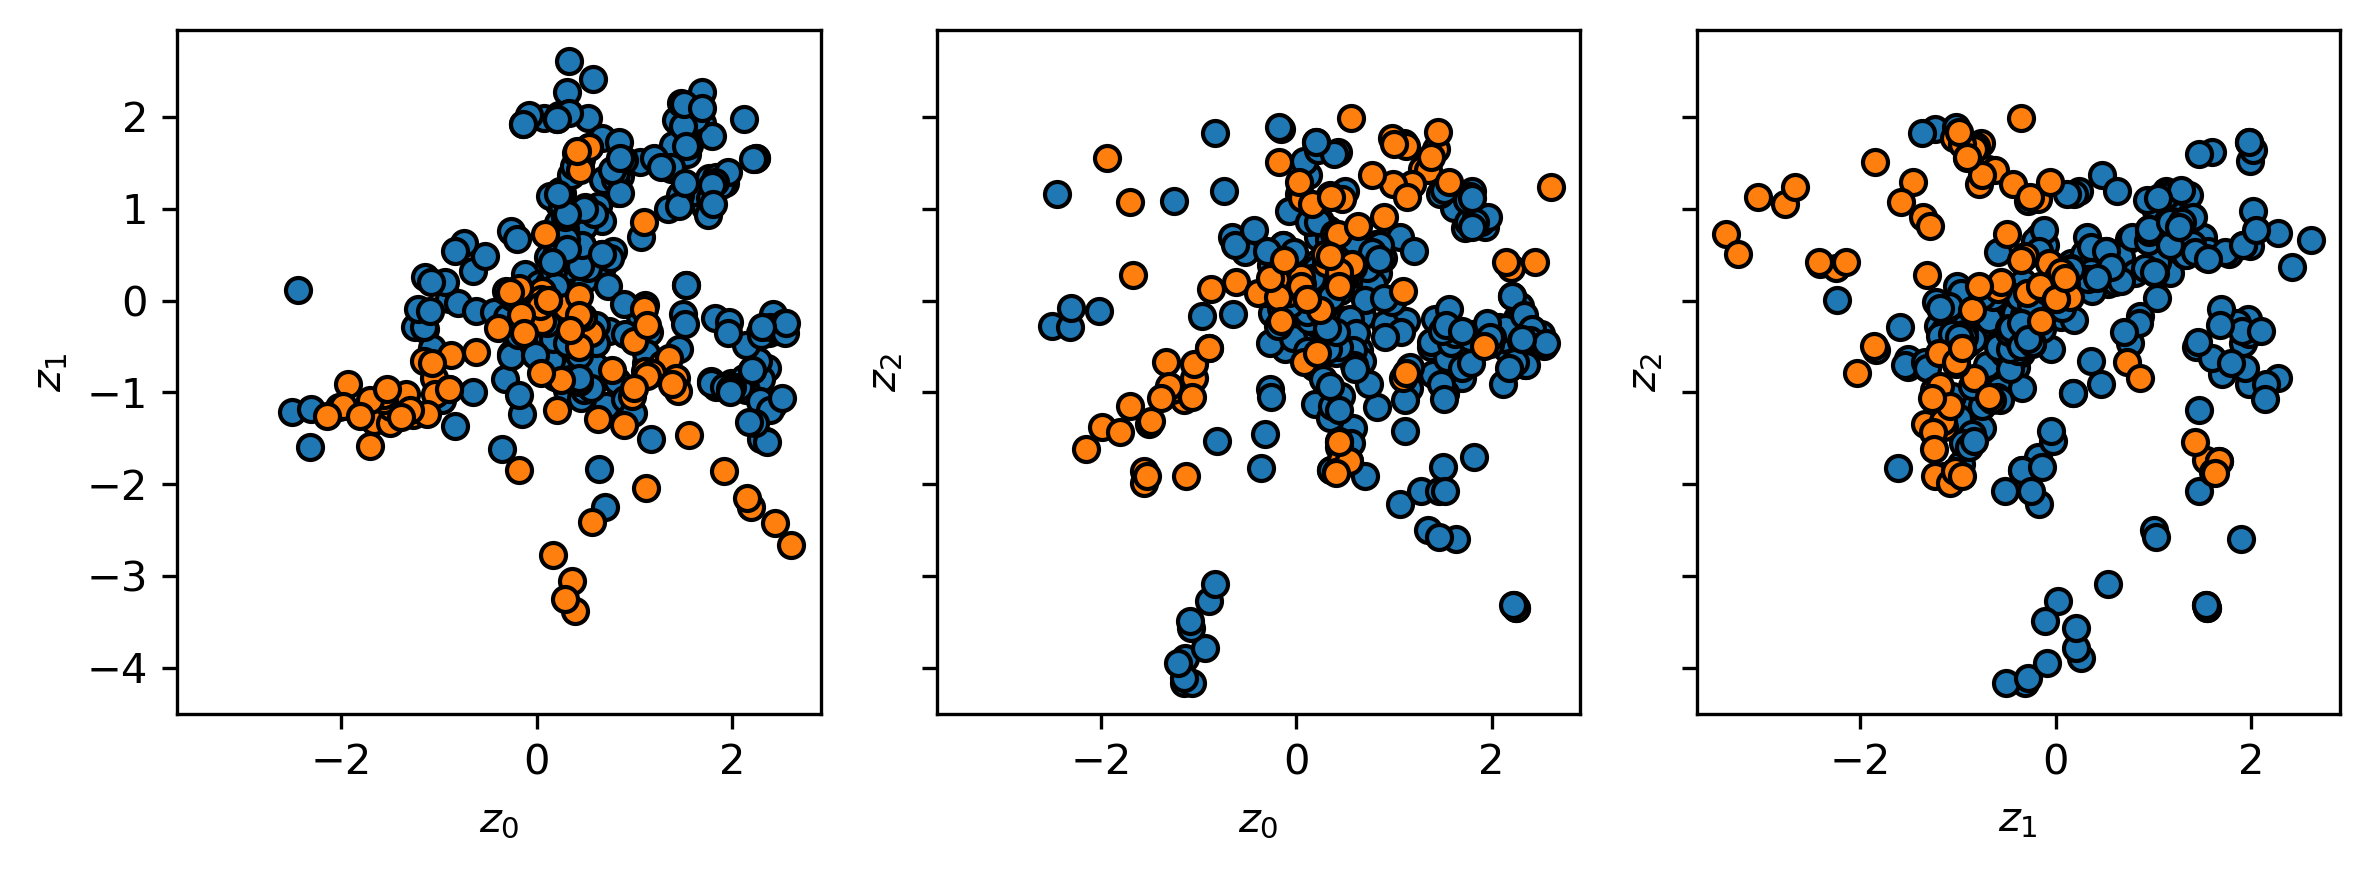

In [19]:
fig, axes = plt.subplots(1,3, figsize = (8,3), dpi = 300, sharex= True, sharey = True )

for label in [tryp, chym]:
    plot1 = axes[0].scatter(
        S1A_z_dim[label,0],
        S1A_z_dim[label,1],
        edgecolor = 'k'
    )
    plot2 = axes[1].scatter(
        S1A_z_dim[label,0],
        S1A_z_dim[label,2],
        edgecolor = 'k'
    )
    plot3 = axes[2].scatter(
        S1A_z_dim[label,1],
        S1A_z_dim[label,2],
        edgecolor = 'k'
    )

#axes[0].set_xlim([-3., 3.]) 
#axes[0].set_ylim([-3., 3.])
#plot1.set_clim([-4, 0.5])

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

plt.tight_layout()

# SH3

In [11]:
# path to collect the sequence data    
main_path = 'data'    
SH3_path = main_path + '/sh3_59.fasta'

# read the sequence data
SH3_sequences = prep.get_seq(SH3_path)

# clean up data
sample, positions = len(SH3_sequences), len(SH3_sequences[0])
SH3_MSA = prep.create_MSA(SH3_sequences, sample, positions)

# pandas dataframe format
SH3_df = pd.DataFrame(SH3_MSA)
SH3_df.columns = ['Sequence']

SH3_onehot_inputs = create_one_hot(SH3_df)

# hyperparameters ...

z_dim, alpha = 3, 0.1
samples, seq_len, aa_var = SH3_onehot_inputs.shape
input_dim = seq_len*aa_var # flatten input tensor
intermediate_dim = input_dim # scalar * intermediate_dim = hidden NN width

In [17]:
batch_size = 64
over_batch = 8
nb_epochs = 50
val_frac = .15

batches_per_epoch = np.int32(over_batch*np.ceil(SH3_onehot_inputs.shape[0]/batch_size))

idx = np.arange(len(SH3_onehot_inputs))

model = MMD_VAE(zdims = z_dim).to(device)
model.train()

v_train, v_val, idx_train, idx_val = \
train_test_split(SH3_onehot_inputs, idx, test_size=val_frac, random_state=randstate+1)

loss_train = []
loss_train_rec = []
loss_train_mmd = []
loss_test = [] 
for epoch in range(1, nb_epochs+1):
    tl, tlr, tlm = train(model, epoch, batches_per_epoch, v_train)
    ltest = test(model, epoch, v_val) # here is reconstruction loss only...
    
    loss_train.append(tl)
    loss_train_rec.append(tlr)
    loss_train_mmd.append(tlm)
    loss_test.append(ltest)

====> Epoch 2 done! Train loss = 3.06e-02, Train loss rec = 2.74e-02, Train loss mmd = 1.61e-03
====> Test loss rec: 2.81e-02

====> Epoch 4 done! Train loss = 3.23e-02, Train loss rec = 2.61e-02, Train loss mmd = 3.10e-03
====> Test loss rec: 2.70e-02

====> Epoch 6 done! Train loss = 2.80e-02, Train loss rec = 2.48e-02, Train loss mmd = 1.61e-03
====> Test loss rec: 2.58e-02

====> Epoch 8 done! Train loss = 2.63e-02, Train loss rec = 2.43e-02, Train loss mmd = 1.02e-03
====> Test loss rec: 2.56e-02

====> Epoch 10 done! Train loss = 2.48e-02, Train loss rec = 2.39e-02, Train loss mmd = 4.53e-04
====> Test loss rec: 2.53e-02

====> Epoch 12 done! Train loss = 2.64e-02, Train loss rec = 2.39e-02, Train loss mmd = 1.25e-03
====> Test loss rec: 2.55e-02

====> Epoch 14 done! Train loss = 2.85e-02, Train loss rec = 2.32e-02, Train loss mmd = 2.63e-03
====> Test loss rec: 2.50e-02

====> Epoch 16 done! Train loss = 2.58e-02, Train loss rec = 2.29e-02, Train loss mmd = 1.46e-03
====> Test 

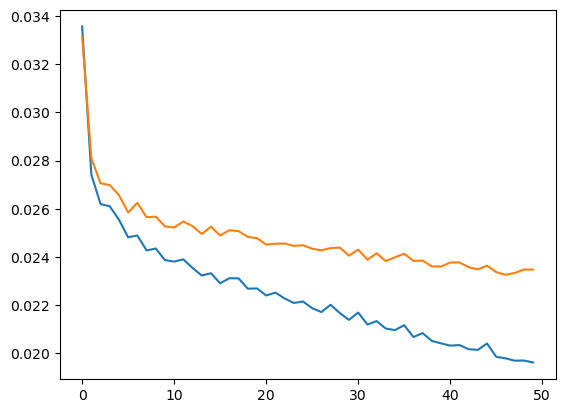

In [18]:
#2e-5
for i in (
loss_train_rec,
#loss_train_MSE,
loss_test,
#loss_val_MSE
         ):
    plt.plot(i)

In [12]:
batch_size = 64
over_batch = 8
nb_epochs = 40

batches_per_epoch = np.int32(over_batch*np.ceil(SH3_onehot_inputs.shape[0]/batch_size))

model = MMD_VAE(zdims = z_dim).to(device)
model.train()

loss_train = []
loss_train_rec = []
loss_train_mmd = []
for epoch in range(1, nb_epochs+1):
    tl, tlr, tlm = train(model, epoch, batches_per_epoch, SH3_onehot_inputs)
    model.eval()
    
    loss_train.append(tl)
    loss_train_rec.append(tlr)
    loss_train_mmd.append(tlm)

====> Epoch 2 done! Train loss = 2.90e-02, Train loss rec = 2.72e-02, Train loss mmd = 8.71e-04
====> Epoch 4 done! Train loss = 3.58e-02, Train loss rec = 2.61e-02, Train loss mmd = 4.88e-03
====> Epoch 6 done! Train loss = 2.77e-02, Train loss rec = 2.51e-02, Train loss mmd = 1.30e-03
====> Epoch 8 done! Train loss = 3.05e-02, Train loss rec = 2.48e-02, Train loss mmd = 2.85e-03
====> Epoch 10 done! Train loss = 2.95e-02, Train loss rec = 2.41e-02, Train loss mmd = 2.70e-03
====> Epoch 12 done! Train loss = 2.44e-02, Train loss rec = 2.36e-02, Train loss mmd = 3.68e-04
====> Epoch 14 done! Train loss = 2.92e-02, Train loss rec = 2.39e-02, Train loss mmd = 2.63e-03
====> Epoch 16 done! Train loss = 2.44e-02, Train loss rec = 2.33e-02, Train loss mmd = 5.78e-04
====> Epoch 18 done! Train loss = 2.61e-02, Train loss rec = 2.31e-02, Train loss mmd = 1.50e-03
====> Epoch 20 done! Train loss = 2.37e-02, Train loss rec = 2.28e-02, Train loss mmd = 4.80e-04
====> Epoch 22 done! Train loss = 

In [13]:
model = model.cpu()
torch.cuda.empty_cache() 

In [24]:
save_path = "output/VAE_SH3.pyt"
torch.save(model.state_dict(), save_path)

In [14]:
nat_df = pd.read_excel('./data/LibraryNatural_Training5299.xls')

In [15]:
nat_df = nat_df.rename(columns = {'Sequence_aligned': 'Sequence'})

In [19]:
# one hot encoded for the natural df with annotated phylogeny
nat_x_OH = create_one_hot(nat_df)

v_all = torch.FloatTensor(nat_x_OH)

nat_z = model.encoder(v_all).detach().numpy() 

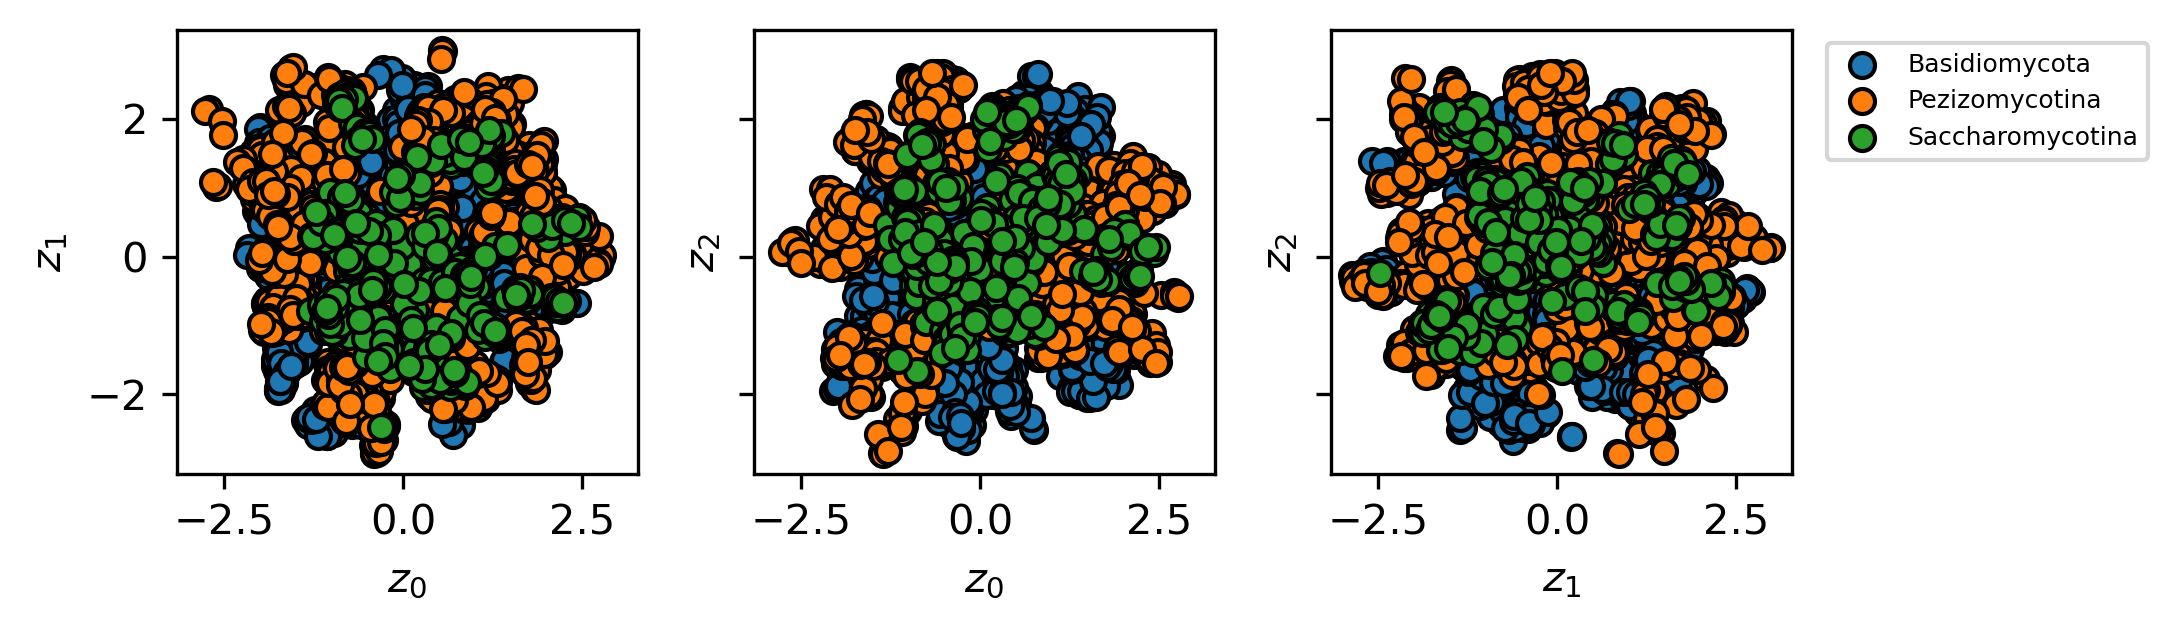

In [20]:
phylogeny = ['Saccharomycotina', 'Pezizomycotina', 'Basidiomycota']


fig, axes = plt.subplots(1,3, figsize = (7.5,2.2), dpi = 300, sharex= True, sharey = True )

for phylo in phylogeny[::-1]:

    phylo_z = nat_z[
    nat_df.Phylogeny.str.contains(phylo)
    ]

    
    axes[0].scatter(
    phylo_z[:,0],
    phylo_z[:,1],
    edgecolor = 'k',
    label  = phylo
    )
    
    axes[1].scatter(
    phylo_z[:,0],
    phylo_z[:,2],
    edgecolor = 'k',
    label  = phylo
    )
 

    axes[2].scatter(
    phylo_z[:,1],
    phylo_z[:,2],
    edgecolor = 'k',
    label  = phylo
    )

axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=6)
plt.tight_layout()



In [21]:
sho1_z = nat_z[nat_df.orthologous_group == 'NOG09120']
bzz1_z = nat_z[
    (nat_df.orthologous_group == 'KOG3565_1') |
    (nat_df.orthologous_group == 'KOG3565_2') |
    (nat_df.orthologous_group == 'KOG3565_3') |
    (nat_df.orthologous_group == 'KOG3565_4') 
    ]
abp1_z = nat_z[nat_df.orthologous_group == 'KOG3655']
rvs167_z = nat_z[nat_df.orthologous_group == 'KOG3771']


In [22]:
sho1_re = nat_df.RE_norm[nat_df.orthologous_group == 'NOG09120']

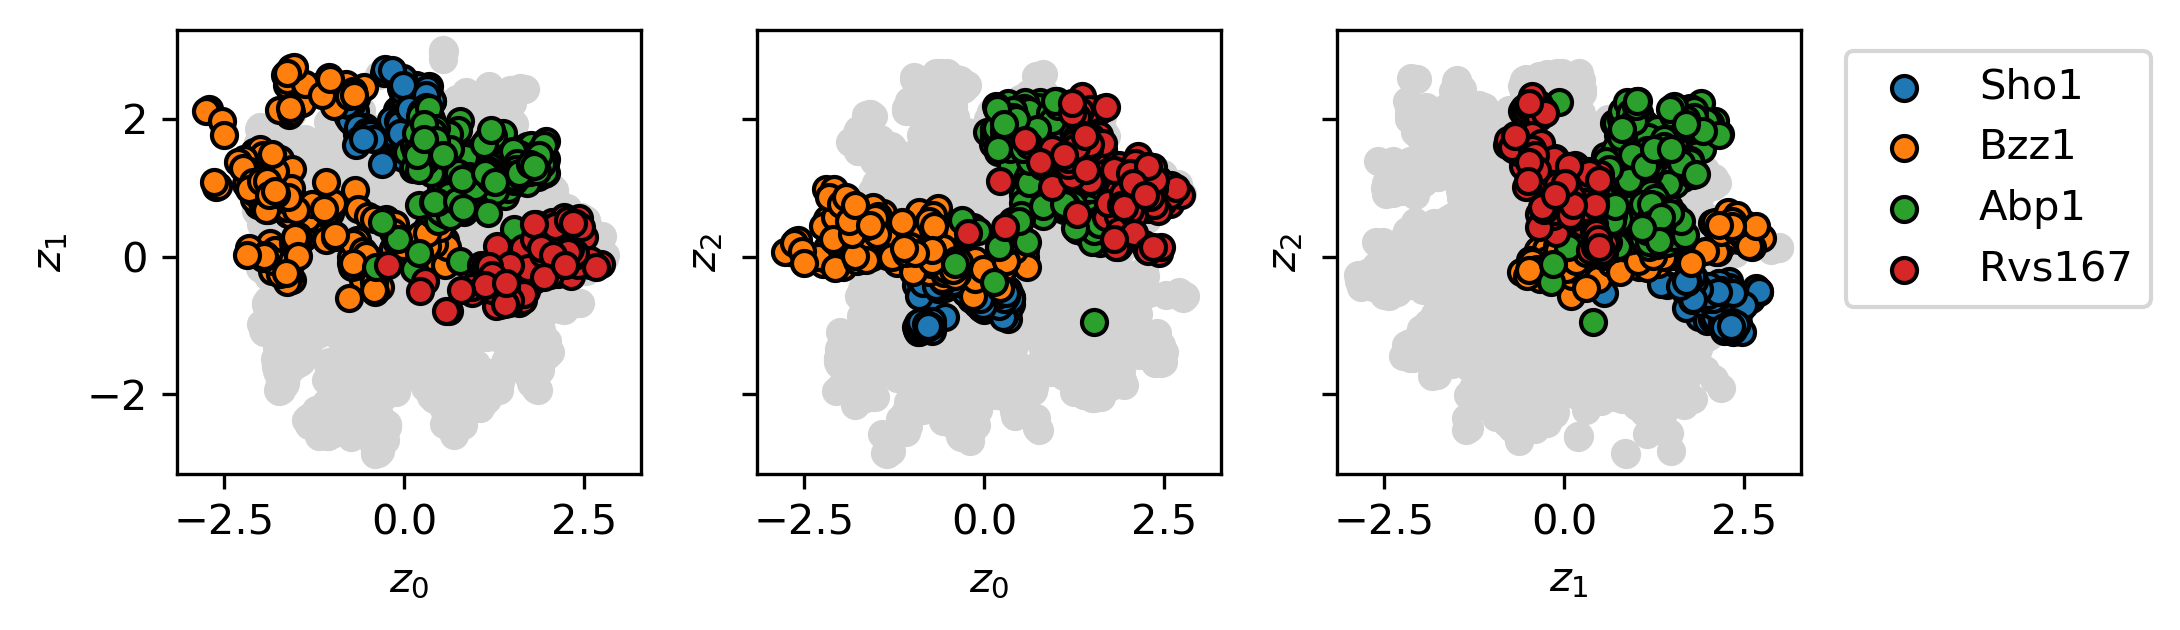

In [23]:

fig, axes = plt.subplots(1,3, figsize = (7.5,2.2), dpi = 300, sharex= True, sharey = True )


# first subplot
axes[0].scatter(
    nat_z[:,0],
    nat_z[:,1],
    color = 'lightgrey'
)
    
axes[0].scatter(
    sho1_z[:,0],
    sho1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    bzz1_z[:,0],
    bzz1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    abp1_z[:,0],
    abp1_z[:,1],
    edgecolor = 'k',
)

axes[0].scatter(
    rvs167_z[:,0],
    rvs167_z[:,1],
    edgecolor = 'k',
)


# second subplot

    
axes[1].scatter(
    nat_z[:,0],
    nat_z[:,2],
    color = 'lightgrey'
)
    
axes[1].scatter(
    sho1_z[:,0],
    sho1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    bzz1_z[:,0],
    bzz1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    abp1_z[:,0],
    abp1_z[:,2],
    edgecolor = 'k',
)

axes[1].scatter(
    rvs167_z[:,0],
    rvs167_z[:,2],
    edgecolor = 'k',
)



# third subplot

axes[2].scatter(
    nat_z[:,1],
    nat_z[:,2],
    color = 'lightgrey'
)
    
axes[2].scatter(
    sho1_z[:,1],
    sho1_z[:,2],
    edgecolor = 'k',
    label = 'Sho1'
)
axes[2].scatter(
    bzz1_z[:,1],
    bzz1_z[:,2],
    edgecolor = 'k',
    label = 'Bzz1'
)

axes[2].scatter(
    abp1_z[:,1],
    abp1_z[:,2],
    edgecolor = 'k',
    label = 'Abp1'
    
)

axes[2].scatter(
    rvs167_z[:,1],
    rvs167_z[:,2],
    edgecolor = 'k',
    label = 'Rvs167'
)




axes[0].set_xlabel('$z_0$')
axes[0].set_ylabel('$z_1$')

axes[1].set_xlabel('$z_0$')
axes[1].set_ylabel('$z_2$')

axes[2].set_xlabel('$z_1$')
axes[2].set_ylabel('$z_2$')

axes[2].legend(loc='upper right', bbox_to_anchor=(1.8, 1),fontsize=10)
plt.tight_layout()

